In [27]:
import os
import sys
sys.path.insert(0,'../../../')
import glob
import chess.pgn
import shutil
import logging
import io
import numpy as np
from pathlib import Path
from DeepCrazyhouse.configs.main_config import main_config
from DeepCrazyhouse.src.preprocessing.game_phase_detector import get_game_phase
from tqdm import tqdm
from copy import deepcopy
import multiprocessing as mp
import json
import matplotlib.pyplot as plt

# Loads and analyses a file created by the analyse_game_phases.py script

In [3]:
with open("analyse_game_phase_data.json", 'r') as f:
    results, all_outcomes_flattened, all_elos_flattened = json.load(f)

In [12]:
all_moves_all_games, all_y_values_all_games, num_moves_all_games, phase_move_counter_all_games, phase_y_values_all_games, phase_moves_all_games = zip(*results)

In [18]:
len(phase_y_values_all_games)

1112647

In [14]:
len(all_outcomes_flattened)

1112647

In [21]:
phase_move_counter_all_games[0]

{'0': 37, '1': 30, '2': 14}

In [22]:
# per position
total_positions_phase0 = 0
total_positions_phase1 = 0
total_positions_phase2 = 0
game_outcomes_all_positions_by_phase = {"0": {-1: 0, 0: 0, 1: 0}, "1": {-1: 0, 0: 0, 1: 0}, "2": {-1: 0, 0: 0, 1: 0}}

# per game
total_games = len(phase_move_counter_all_games)
games_considered_phase0 = 0
games_considered_phase1 = 0
games_considered_phase2 = 0
game_outcomes_by_phase = {"0": {-1: 0, 0: 0, 1: 0}, "1": {-1: 0, 0: 0, 1: 0}, "2": {-1: 0, 0: 0, 1: 0}}

for idx, game_phase_move_counter in enumerate(phase_move_counter_all_games):

    game_outcome = all_outcomes_flattened[idx]
    num_opening_moves = game_phase_move_counter["0"]
    num_midgame_moves = game_phase_move_counter["1"]
    num_endgame_moves = game_phase_move_counter["2"]
    
    total_positions_phase0 += num_opening_moves
    total_positions_phase1 += num_midgame_moves
    total_positions_phase2 += num_endgame_moves
    game_outcomes_all_positions_by_phase["0"][game_outcome] += num_opening_moves
    game_outcomes_all_positions_by_phase["1"][game_outcome] += num_midgame_moves
    game_outcomes_all_positions_by_phase["2"][game_outcome] += num_endgame_moves

    if num_opening_moves > 0:
        games_considered_phase0 += 1
        game_outcomes_by_phase["0"][game_outcome] += 1

    if num_midgame_moves > 0:
        games_considered_phase1 += 1
        game_outcomes_by_phase["1"][game_outcome] += 1

    if num_endgame_moves > 0:
        games_considered_phase2 += 1
        game_outcomes_by_phase["2"][game_outcome] += 1


total_positions = total_positions_phase0 + total_positions_phase1 + total_positions_phase2

In [23]:
total_positions_phase0, total_positions_phase1, total_positions_phase2

(26212273, 36287651, 28914027)

In [24]:
game_outcomes_all_positions_by_phase

{'0': {-1: 6701373, 0: 10367949, 1: 9142951},
 '1': {-1: 10510981, 0: 11739024, 1: 14037646},
 '2': {-1: 7756795, 0: 11395517, 1: 9761715}}

In [25]:
total_games, games_considered_phase0, games_considered_phase1, games_considered_phase2

(1112647, 1112647, 1077136, 754899)

1.0 0.968084217186583 0.6784712491922416


([<matplotlib.axis.XTick at 0x25dc569fd30>,
 [Text(0, 0, 'opening'), Text(1, 0, 'midgame'), Text(2, 0, 'endgame')])

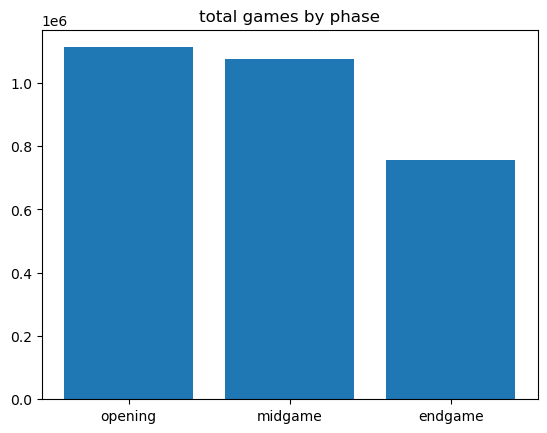

In [29]:
# total games by phase
print(games_considered_phase0/total_games, games_considered_phase1/total_games, games_considered_phase2/total_games)
plt.bar(list(range(3)), [games_considered_phase0, games_considered_phase1, games_considered_phase2], align="center")
plt.title("total games by phase")
plt.xticks(list(range(3)), ["opening", "midgame", "endgame"])

([<matplotlib.axis.XTick at 0x25dc55de7c0>,
 [Text(0, 0, 'opening'), Text(1, 0, 'midgame'), Text(2, 0, 'endgame')])

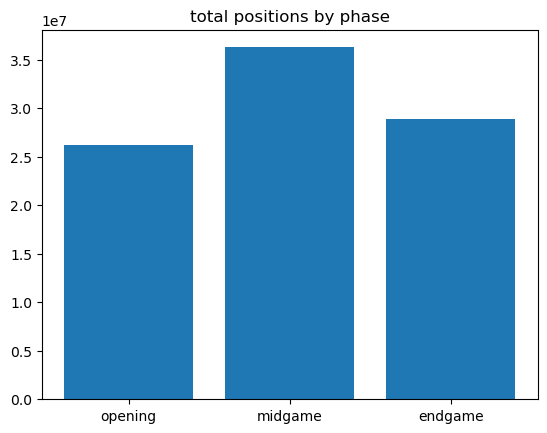

In [28]:
# total positions by phase
plt.bar(list(range(3)), [total_positions_phase0, total_positions_phase1, total_positions_phase2], align="center")
plt.title("total positions by phase")
plt.xticks(list(range(3)), ["opening", "midgame", "endgame"])

In [30]:
num_draws_total = all_outcomes_flattened.count(0)
num_white_wins_total = all_outcomes_flattened.count(1)
num_black_wins_total = all_outcomes_flattened.count(-1)

[0.34414778451746153, 0.40363565443487465, 0.2522165610476638]


([<matplotlib.axis.XTick at 0x25dc808dfa0>,
 [Text(0, 0, 'white_win'), Text(1, 0, 'draw'), Text(2, 0, 'black_win')])

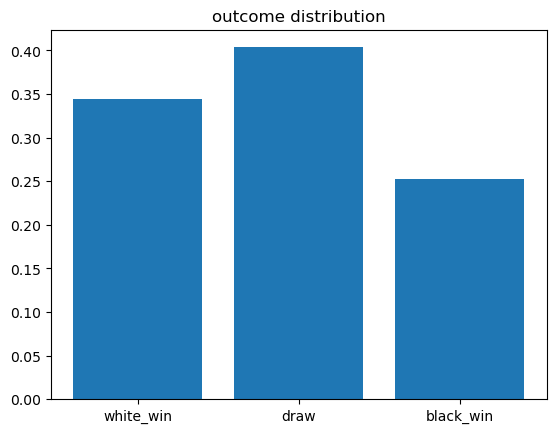

In [34]:
# outcome distribution
outcomes_distribution_phase0 = [game_outcomes_by_phase["0"][1]/total_games, game_outcomes_by_phase["0"][0]/total_games, game_outcomes_by_phase["0"][-1]/total_games]
print(outcomes_distribution_phase0)
plt.bar(list(range(3)), outcomes_distribution_phase0, align="center")
plt.title("outcome distribution")
plt.xticks(list(range(3)), ["white_win", "draw", "black_win"])

[0.3547379346712021, 0.3851723459247486, 0.26008971940404924]


([<matplotlib.axis.XTick at 0x25dc8290370>,
 [Text(0, 0, 'white_win'), Text(1, 0, 'draw'), Text(2, 0, 'black_win')])

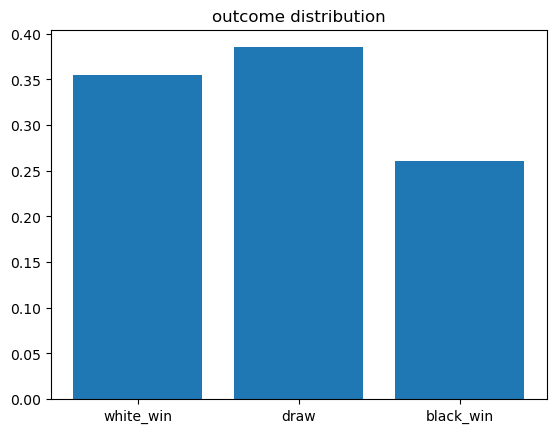

In [39]:
# outcome distribution
outcomes_distribution_phase0 = [game_outcomes_by_phase["1"][1]/games_considered_phase1, game_outcomes_by_phase["1"][0]/games_considered_phase1, game_outcomes_by_phase["1"][-1]/games_considered_phase1]
print(outcomes_distribution_phase0)
plt.bar(list(range(3)), outcomes_distribution_phase0, align="center")
plt.title("outcome distribution")
plt.xticks(list(range(3)), ["white_win", "draw", "black_win"])

[0.3618828479041567, 0.3609807404699172, 0.2771364116259261]


([<matplotlib.axis.XTick at 0x25dc822a1c0>,
 [Text(0, 0, 'white_win'), Text(1, 0, 'draw'), Text(2, 0, 'black_win')])

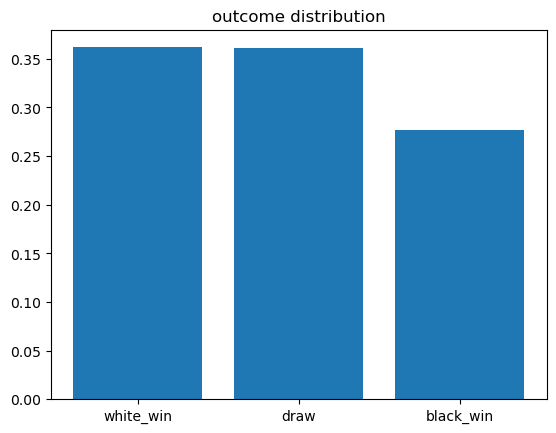

In [38]:
# outcome distribution
outcomes_distribution_phase0 = [game_outcomes_by_phase["2"][1]/games_considered_phase2, game_outcomes_by_phase["2"][0]/games_considered_phase2, game_outcomes_by_phase["2"][-1]/games_considered_phase2]
print(outcomes_distribution_phase0)
plt.bar(list(range(3)), outcomes_distribution_phase0, align="center")
plt.title("outcome distribution")
plt.xticks(list(range(3)), ["white_win", "draw", "black_win"])